### Data Analysis

In [2]:
import requests
import pandas as pd

url = "https://file.notion.so/f/f/f3d54618-4ee1-480d-b8f7-25c361e2c7b2/12d14740-f5b4-4ce9-9d4d-b9d0b3cd5548/data.parquet?table=block&id=6fa5d867-4063-4844-aebb-4be60a25af39&spaceId=f3d54618-4ee1-480d-b8f7-25c361e2c7b2&expirationTimestamp=1764504000000&signature=c4NY6s1sPiTpV2zTDfB_nX9ofciDWMP2wE2PUg-HD6M&downloadName=data.parquet"

r = requests.get(url)
with open("data.parquet", "wb") as f:
    f.write(r.content)

df = pd.read_parquet("data.parquet")
print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [3]:
df = df.reset_index()
print(df)

                      time  banknifty     nifty  tte
0      2021-01-01 09:15:00   0.286058  0.199729   27
1      2021-01-01 09:16:00   0.285381  0.200433   27
2      2021-01-01 09:17:00   0.284233  0.200004   27
3      2021-01-01 09:18:00   0.286104  0.199860   27
4      2021-01-01 09:19:00   0.285539  0.198951   27
...                    ...        ...       ...  ...
690507 2022-06-30 15:26:00   0.240701  0.214758   28
690508 2022-06-30 15:27:00   0.240875  0.216558   28
690509 2022-06-30 15:28:00   0.242115  0.216794   28
690510 2022-06-30 15:29:00   0.243426  0.216455   28
690511 2022-06-30 15:30:00   0.241907  0.216081   28

[690512 rows x 4 columns]


In [4]:
####### I have to find, how many times Consecutive missing blocks are there

### 1.I can remove this row completely
### 2.Using KNN or mean(upper + lower)/2 to fill the missing value(if not consecutive)
### 3.ffill() or bfill() for consecutive missing values(I can)

# df = df.dropna(how='any')
# df.isna().sum()
df.isna()
df.isna().sum()

df = df.ffill()
df.isna().sum()

time         0
banknifty    0
nifty        0
tte          0
dtype: int64

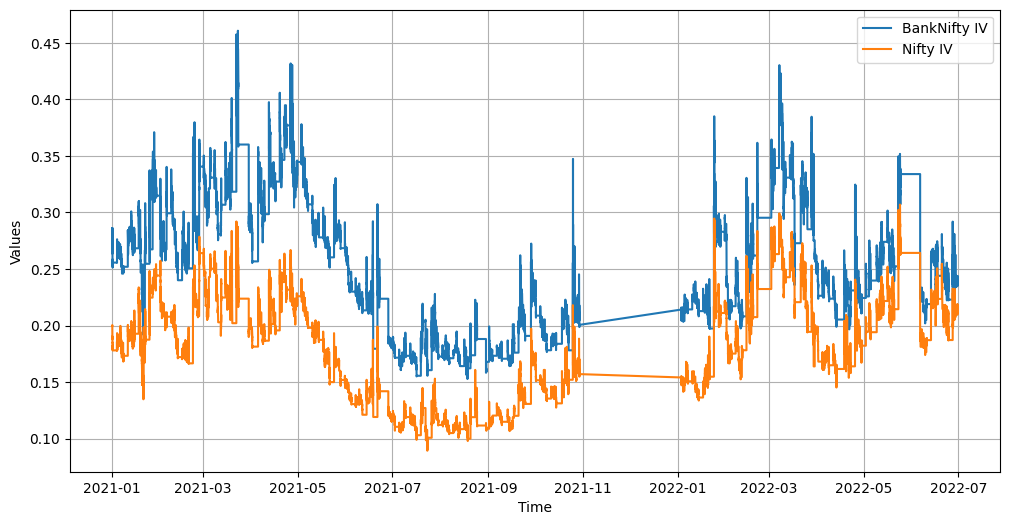

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['time'], df['banknifty'], label='BankNifty IV')
plt.plot(df['time'], df['nifty'], label='Nifty IV')
# plt.plot(df['time'], df['tte'], label='TTE')

plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

### Base Model

In [6]:
### using spread in IV between nifty and banknifty,
### 1.banknifty_iv becomes too high relative to nifty_iv -->sell banknifty
### 2.banknifty_iv becomes too low relative to nifty_iv  -->buy banknifty
### this position directly depends on, how close are to expiry(TTE^0.7)

# When z-score crosses an upper threshold, go SHORT:
# Sell stock A
# Buy stock B
# When the z-score crosses the lower threshold, go LONG:
# Buy stock A
# Sell stock B


In [ ]:
### 1.I have to add Cointegration test(is the spread stationary or not) if p-value < 0.05 then trade
### Not using in this task

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

############# Cointegration Test Class(for improvement of z-score trade) #############
class CointegrationTester:
    def __init__(self, critical_pvalue=0.05):
        self.critical_pvalue = critical_pvalue
        self.pvalue = None
        self.is_cointegrated = None
        self.hedge_ratio = None

    def test(self, series_y, series_x):
        # 1. Run Engle-Granger test
        score, pvalue, _ = coint(series_y, series_x)
        self.pvalue = pvalue
        self.is_cointegrated = pvalue < self.critical_pvalue

        # 2. Estimate hedge ratio with OLS
        X = sm.add_constant(series_x)
        model = sm.OLS(series_y, X).fit()
        self.hedge_ratio = model.params[1]

        return {
            "pvalue": self.pvalue,
            "is_cointegrated": self.is_cointegrated,
            "hedge_ratio": self.hedge_ratio
        }

In [8]:
import numpy as np
import pandas as pd


############ This calulates spread and zscore ##########
class SpreadCalculator:
    def __init__(self, window=20):
        self.window = window

    def compute_spread(self, df):
        df['spread'] = df['banknifty'] - df['nifty']
        # ci = CointegrationTester()
        # result = ci.test(df['banknifty'], df['nifty'])

        # hedge = result['hedge_ratio']
        # df['spread'] = df['banknifty'] - hedge * df['nifty']

        return df

    def compute_zscore(self, df):
        df['spread_mean'] = df['spread'].rolling(self.window).mean()
        df['spread_std']  = df['spread'].rolling(self.window).std()
        df['zscore']      = (df['spread'] - df['spread_mean']) / df['spread_std']
        df['zscore']      = df['zscore'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df



In [ ]:

############# This class stores the trade data ##############
class PairTrade:
    def __init__(self, entry_time, entry_z, entry_spread, entry_mean, tte):
        self.entry_time     = entry_time
        self.entry_z        = entry_z               
        self.entry_spread   = entry_spread
        self.entry_mean     = entry_mean            
        self.tte            = tte
        self.direction      = "LONG" if entry_z < 0 else "SHORT"

        self.exit_time      = None
        self.exit_spread    = None
        self.exit_z         = None                  
        self.exit_mean      = None                  
        self.pnl            = None

    def close(self, exit_time, exit_spread, exit_z, exit_mean):
        self.exit_time   = exit_time
        self.exit_spread = exit_spread
        self.exit_z      = exit_z
        self.exit_mean   = exit_mean

        if self.direction == "LONG":
            self.pnl = (self.entry_spread - exit_spread) * (self.tte ** 0.7)
        else:
            self.pnl = (exit_spread - self.entry_spread) * (self.tte ** 0.7)

        return self.pnl


In [ ]:
# ############# Pair Trading Main Class #############
# class PairTradingStrategy:
#     def __init__(self, upper, lower, exit_threshold, window):
#         self.upper          = upper
#         self.lower          = lower
#         self.exit_threshold = exit_threshold

#         self.spread_model   = SpreadCalculator(window)
#         self.open_trade     = None
#         self.ledger         = []

#     def process(self, df):

#         df = self.spread_model.compute_spread(df)
#         df = self.spread_model.compute_zscore(df)

#         for idx, row in df.iterrows():
#             current_time = idx  
#             z            = row['zscore']
#             spread       = row['spread']
#             mean_val     = row['spread_mean']
#             tte          = row['tte']

#             ########### ENTRY CONDITIONS ###########
#             if self.open_trade is None:
#                 if z > self.upper or z < self.lower:
#                     self.open_trade = PairTrade(
#                         entry_time   = current_time,
#                         entry_z      = z,
#                         entry_spread = spread,
#                         entry_mean   = mean_val,
#                         tte          = tte
#                     )

#             ########### EXIT CONDITIONS ###########
#             else:
#                 if abs(z) < self.exit_threshold:
#                     pnl = self.open_trade.close(
#                         exit_time   = current_time,
#                         exit_spread = spread,
#                         exit_z      = z,
#                         exit_mean   = mean_val
#                     )

#                     self.ledger.append({
#                         "entry_time": self.open_trade.entry_time,
#                         "exit_time": current_time,
#                         "direction": self.open_trade.direction,

#                         #### Spread values
#                         "entry_spread": self.open_trade.entry_spread,
#                         "exit_spread": spread,

#                         #### Z-scores
#                         "entry_zscore": self.open_trade.entry_z,
#                         "exit_zscore": z,

#                         ##### Mean spread values
#                         "entry_mean_zscore": self.open_trade.entry_mean,
#                         "exit_mean_zscore": mean_val,

#                         #### P/L
#                         "pnl": pnl
#                     })

#                     self.open_trade = None

#         return pd.DataFrame(self.ledger)

In [ ]:
class PairTrade:
    def __init__(self, entry_time, entry_z, entry_spread, entry_mean, tte, direction):
        self.entry_time   = entry_time
        self.entry_z      = entry_z
        self.entry_spread = entry_spread
        self.entry_mean   = entry_mean
        self.tte          = tte
        self.direction    = direction 

    def close(self, exit_time, exit_spread, exit_z, exit_mean):
        # LONG: profit when spread increases
        # SHORT: profit when spread decreases

        if self.direction == "LONG":
            pnl = exit_spread - self.entry_spread
        else:  # SHORT
            pnl = self.entry_spread - exit_spread

        self.exit_time   = exit_time
        self.exit_z      = exit_z
        self.exit_spread = exit_spread
        self.exit_mean   = exit_mean

        return pnl

class PairTradingStrategy:
    def __init__(self, upper, lower, exit_threshold, window,
                 bnIV_sl=None, nfIV_sl=None):
        
        self.upper          = upper
        self.lower          = lower
        self.exit_mid       = (upper + lower) / 2      # EXIT point
        self.bnIV_sl        = bnIV_sl                 # Stop Loss thresholds
        self.nfIV_sl        = nfIV_sl
        self.spread_model   = SpreadCalculator(window)

        self.open_trade     = None
        self.ledger         = []

    def process(self, df):

        df = self.spread_model.compute_spread(df)
        df = self.spread_model.compute_zscore(df)

        for idx, row in df.iterrows():

            current_time = idx  
            z            = row['zscore']
            spread       = row['spread']
            mean_val     = row['spread_mean']
            bankIV       = row['banknifty']
            niftyIV      = row['nifty']
            tte          = row['tte']

            ########### ENTRY CONDITIONS ###########
            if self.open_trade is None:

                # SHORT ENTRY at upper band
                if z > self.upper:
                    self.open_trade = PairTrade(
                        entry_time   = current_time,
                        entry_z      = z,
                        entry_spread = spread,
                        entry_mean   = mean_val,
                        tte          = tte,
                        direction    = "SHORT"
                    )

                # LONG ENTRY at lower band
                elif z < self.lower:
                    self.open_trade = PairTrade(
                        entry_time   = current_time,
                        entry_z      = z,
                        entry_spread = spread,
                        entry_mean   = mean_val,
                        tte          = tte,
                        direction    = "LONG"
                    )

            ########### EXIT CONDITIONS ###########
            else:

                sl_hit = False
                if self.bnIV_sl is not None and bankIV > self.bnIV_sl:
                    sl_hit = True
                if self.nfIV_sl is not None and niftyIV > self.nfIV_sl:
                    sl_hit = True

                # Stop-loss triggered
                if sl_hit:
                    pnl = self.open_trade.close(
                        exit_time   = current_time,
                        exit_spread = spread,
                        exit_z      = z,
                        exit_mean   = mean_val
                    )

                    self.ledger.append(self._make_ledger_entry(
                        current_time, spread, z, mean_val, pnl
                    ))
                    self.open_trade = None
                    continue

                # EXIT AT MIDPOINT OF BANDS (new exit logic)
                if self.open_trade.direction == "SHORT":
                    if z <= self.exit_mid:
                        pnl = self.open_trade.close(
                            exit_time   = current_time,
                            exit_spread = spread,
                            exit_z      = z,
                            exit_mean   = mean_val
                        )

                        self.ledger.append(self._make_ledger_entry(
                            current_time, spread, z, mean_val, pnl
                        ))
                        self.open_trade = None

                elif self.open_trade.direction == "LONG":
                    if z >= self.exit_mid:
                        pnl = self.open_trade.close(
                            exit_time   = current_time,
                            exit_spread = spread,
                            exit_z      = z,
                            exit_mean   = mean_val
                        )

                        self.ledger.append(self._make_ledger_entry(
                            current_time, spread, z, mean_val, pnl
                        ))
                        self.open_trade = None

        return pd.DataFrame(self.ledger)



    def _make_ledger_entry(self, exit_time, spread, z, mean_val, pnl):
        return {
            "entry_time"       : self.open_trade.entry_time,
            "exit_time"        : exit_time,
            "direction"        : self.open_trade.direction,

            # Spread
            "entry_spread"     : self.open_trade.entry_spread,
            "exit_spread"      : spread,

            # Z-score
            "entry_zscore"     : self.open_trade.entry_z,
            "exit_zscore"      : z,

            # mean
            "entry_mean_zscore": self.open_trade.entry_mean,
            "exit_mean_zscore" : mean_val,

            # P/L
            "pnl"              : pnl
        }


In [44]:
strategy = PairTradingStrategy(upper=1.26, lower=-1.26, exit_threshold=0.1, window=30)
ledger = strategy.process(df)
print(ledger)

      entry_time  exit_time direction  entry_spread  exit_spread  \
0             29         45      LONG      0.078458     0.079353   
1             53         62      LONG      0.075791     0.078335   
2             64         70     SHORT      0.079242     0.077263   
3             73         76     SHORT      0.080146     0.077342   
4             95        109     SHORT      0.079848     0.076578   
...          ...        ...       ...           ...          ...   
8020      690445     690449     SHORT      0.026418     0.024590   
8021      690454     690455     SHORT      0.026546     0.024200   
8022      690459     690467     SHORT      0.026158     0.025251   
8023      690472     690492     SHORT      0.027703     0.026356   
8024      690496     690510      LONG      0.024572     0.026971   

      entry_zscore  exit_zscore  entry_mean_zscore  exit_mean_zscore       pnl  
0        -1.439055     0.273898           0.082597          0.078916  0.000895  
1        -3.253030   

In [45]:
import matplotlib.pyplot as plt

def plot_pair_trading_dual_axis_time_range(df, ledger, strategy, start_time=None, end_time=None):
    # Ensure time column is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index('time')

    # Filter by time range if provided
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
        df = df[df.index >= start_time]
        if not ledger.empty:
            ledger = ledger[pd.to_datetime(ledger['entry_time']) >= start_time]

    if end_time is not None:
        end_time = pd.to_datetime(end_time)
        df = df[df.index <= end_time]
        if not ledger.empty:
            ledger = ledger[pd.to_datetime(ledger['exit_time']) <= end_time]

    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Left y-axis: BankNifty & Nifty IV
    ax1.plot(df.index, df['banknifty'], label='BankNifty IV', color='blue')
    ax1.plot(df.index, df['nifty'], label='Nifty IV', color='green')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("IV Values")
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Right y-axis: Z-score
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['zscore'], label='Z-score', color='orange', linewidth=1.0)
    ax2.axhline(strategy.upper, color='red', linestyle='--', label='Upper threshold')
    ax2.axhline(strategy.lower, color='red', linestyle='--', label='Lower threshold')
    ax2.axhline(0, color='black', linewidth=0.5)

    # Entry/Exit points
    if not ledger.empty:
        ledger = ledger.copy()
        ledger['entry_time'] = pd.to_datetime(ledger['entry_time'])
        ledger['exit_time'] = pd.to_datetime(ledger['exit_time'])

        ax2.scatter(ledger['entry_time'], ledger['entry_zscore'], color='green', s=50, label='Entry', zorder=5)
        ax2.scatter(ledger['exit_time'], ledger['exit_zscore'], color='red', s=50, label='Exit', zorder=5)

    ax2.set_ylabel("Z-score")
    ax2.legend(loc='upper right')

    plt.title(f"Pair Trading – IVs and Z-score ({start_time} to {end_time})")
    plt.tight_layout()
    plt.show()


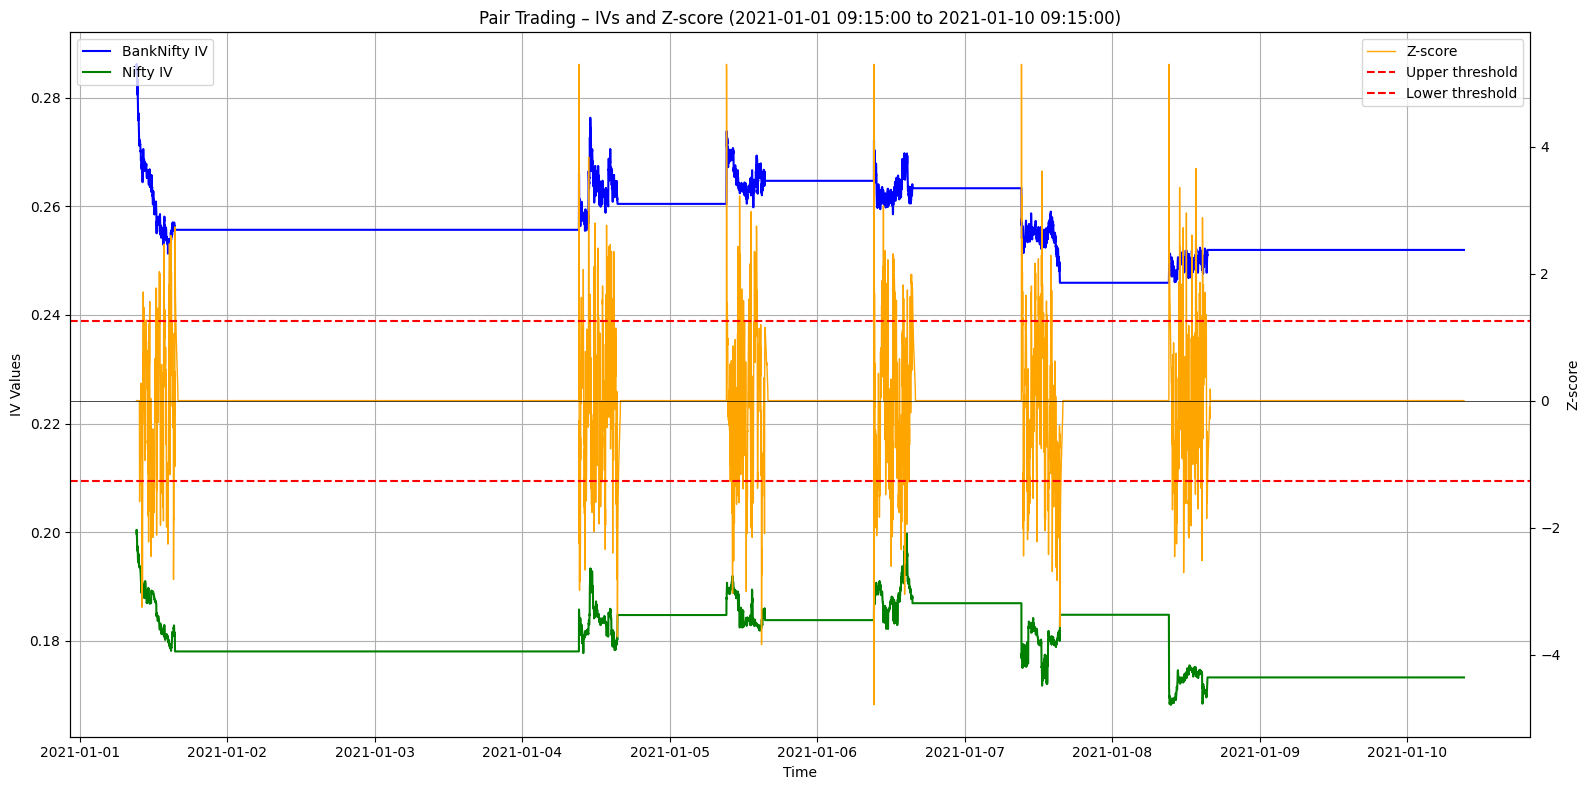

      entry_time  exit_time
0             29         45
1             53         62
2             64         70
3             73         76
4             95        109
...          ...        ...
8020      690445     690449
8021      690454     690455
8022      690459     690467
8023      690472     690492
8024      690496     690510

[8025 rows x 2 columns]


In [46]:
plot_pair_trading_dual_axis_time_range(df, ledger, strategy, start_time='2021-01-01 09:15:00', end_time='2021-01-10 09:15:00')
print(ledger[['entry_time', 'exit_time']])


In [47]:
class StrategyMetrics:    
    def __init__(self, ledger_df):
        self.ledger = ledger_df.copy()
        if self.ledger.empty:
            raise ValueError("Ledger is empty, No trades executed.")

        self.returns = self.ledger["pnl"]

    def total_pnl(self):
        return self.returns.sum()

    def sharpe_ratio(self):
        if self.returns.std() == 0:
            return 0
        return (self.returns.mean() / self.returns.std()) * np.sqrt(252)

    def max_drawdown(self):
        cum = self.returns.cumsum()
        roll_max = cum.cummax()
        drawdown = roll_max - cum
        return drawdown.max()

    def win_rate(self):
        wins = (self.returns > 0).sum()
        total = len(self.returns)
        return wins / total

    def avg_win(self):
        wins = self.returns[self.returns > 0]
        return wins.mean() if len(wins) > 0 else 0

    def avg_loss(self):
        losses = self.returns[self.returns < 0]
        return losses.mean() if len(losses) > 0 else 0

    def profit_factor(self):
        total_win = self.returns[self.returns > 0].sum()
        total_loss = abs(self.returns[self.returns < 0].sum())
        return total_win / total_loss if total_loss != 0 else np.inf

    def expectancy(self):
        return self.returns.mean()  #avg. p/l per trade

    def summary(self):
        return {
            "Total PnL": self.total_pnl(),
            "Sharpe Ratio": self.sharpe_ratio(),
            "Max Drawdown": self.max_drawdown(),
            "Win Rate": self.win_rate(),
            "Avg Win": self.avg_win(),
            "Avg Loss": self.avg_loss(),
            "Profit Factor": self.profit_factor(),
            "Expectancy": self.expectancy(),
            "Number of Trades": len(self.returns)
        }

In [48]:
metrics = StrategyMetrics(ledger)
print(metrics.summary())

{'Total PnL': 37.74392885, 'Sharpe Ratio': 7.046936460727671, 'Max Drawdown': 0.03664400000000079, 'Win Rate': 0.914018691588785, 'Avg Win': 0.005380433210633947, 'Avg Loss': -0.0026649361455108366, 'Profit Factor': 22.924403157331444, 'Expectancy': 0.004703293314641745, 'Number of Trades': 8025}
